In [1]:
# First we load the libraries we'll need
import numpy as np
import scipy
from astropy.io import fits

# Configure the plotting
import matplotlib as mpl
import matplotlib.pyplot as pl
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
# Read in the Kepler data for star number 011904151
f = fits.open("kplr011904151-2009350155506_lpd-targ.fits.gz")
good_quality = f[1].data['QUALITY'] == 0
time = f[1].data["TIME"][good_quality]
flux = f[1].data["FLUX"][good_quality]

In [3]:
# Let's have a look at the first image in the data
np.set_printoptions(precision=0, suppress=True)
print(flux[0][2:-2, 2:-2])

[[    180.     119.     168.     599.     252.      97.      67.]
 [    102.     266.    2413.   56174.    5726.     694.     180.]
 [    316.    3807.   36385.  167883.   69027.   12881.    1282.]
 [    311.    1741.    8995.   79870.   20889.    1317.     279.]
 [     39.     165.    3032.   18694.    8982.     861.      50.]
 [     31.     121.    1809.    9233.    5675.     889.      70.]]


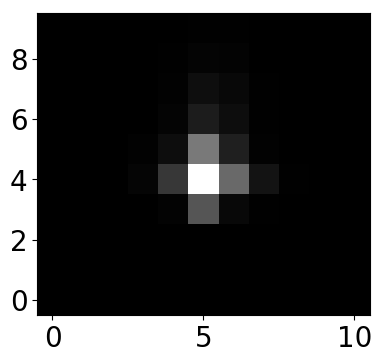

In [4]:
pl.imshow(flux[0], cmap='gray', aspect='equal', interpolation='nearest', origin='lower')

In [5]:
# Find the pixels which are consistently above the mean
median_image = np.nanmedian(flux, axis=0)
median_image[np.isnan(median_image)] = 0.
mask = median_image > (np.nanmean(flux) + 0.1*np.nanstd(flux))
print(mask)

[[False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False  True  True False False False False]
 [False False False False  True  True  True  True False False False]
 [False False False False  True  True  True False False False False]
 [False False False False False  True  True False False False False]
 [False False False False False  True False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]]


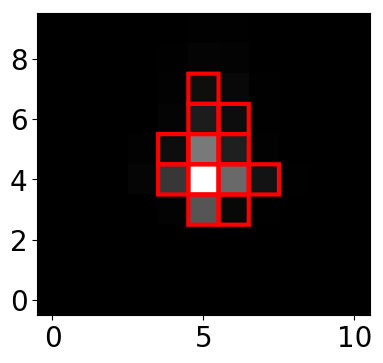

In [6]:
# Visualize the above mask with red squares
ax = pl.imshow(flux[0], cmap='gray', aspect='equal', interpolation='nearest', origin="lower")
for col in range(flux.shape[1]):
    for row in range(flux.shape[2]):
        if mask[col, row]:
            ax.axes.add_patch(mpl.patches.Rectangle((row-.5, col-.5), 1, 1, hatch='', fill=False, snap=False, color='red', lw=3))

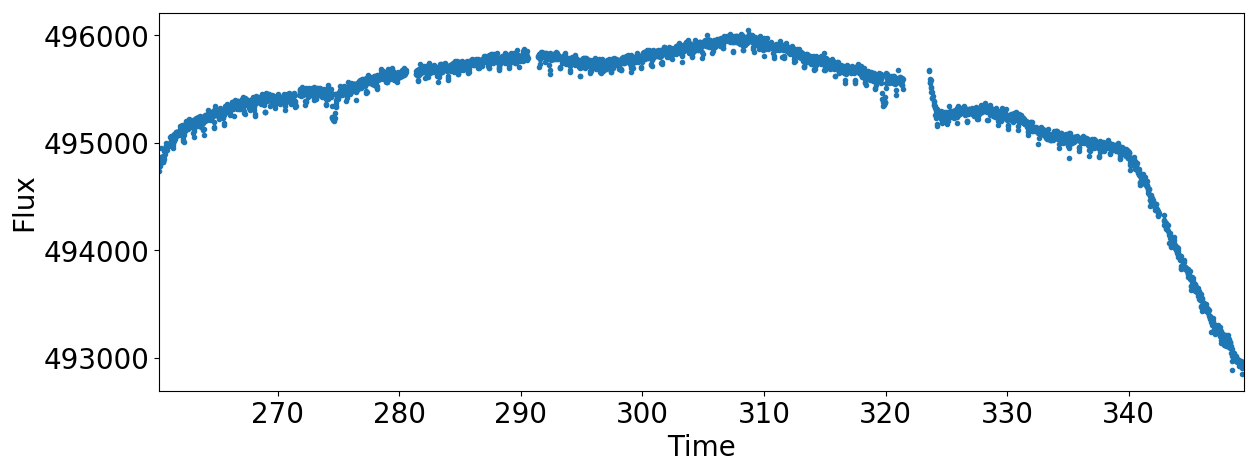

In [7]:
# Let's create a lightcurve by summing the flux in all the time cadences
lightcurve = np.array([np.sum(flux[idx][mask]) for idx in range(flux.shape[0])])
# Plot the result
pl.figure(figsize=(14, 5))
pl.plot(time, lightcurve, '.')
pl.xlim([time[0], time[-1]])
pl.xlabel("Time")
pl.ylabel("Flux")

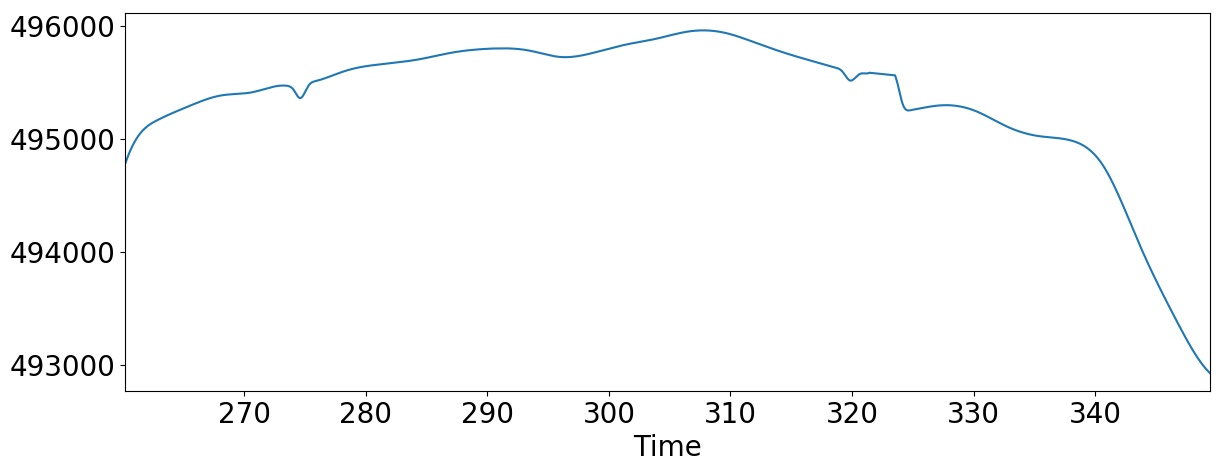

In [8]:
# Let's fit a spline to remove the long-term trends, which we don't care about
from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(time, lightcurve, s=5e6) 
pl.figure(figsize=(14, 5))
pl.plot(time, spline(time), '-')
pl.xlim([time[0], time[-1]])
pl.xlabel("Time")

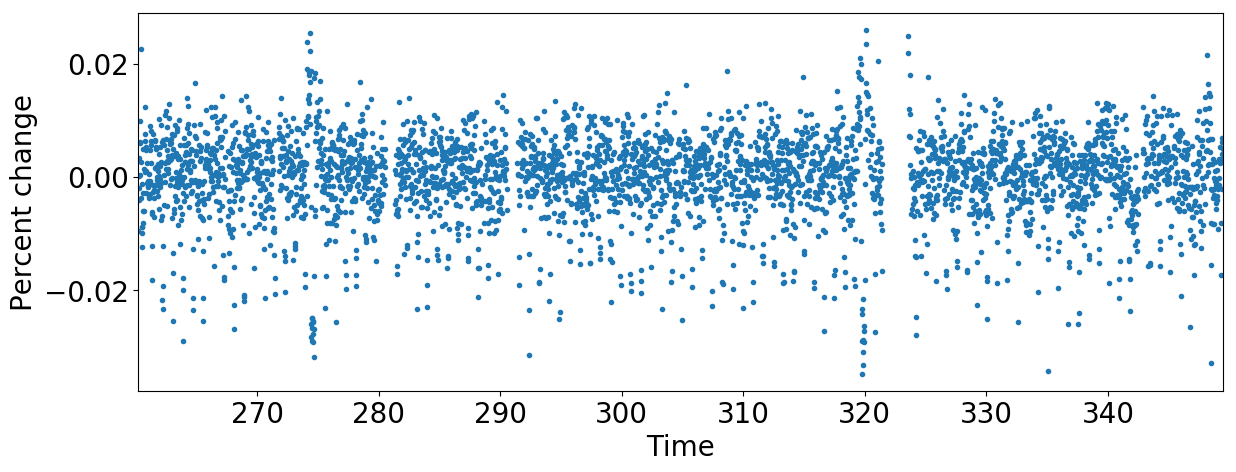

In [25]:
# Divide by the spline to remove the long-term trend
detrended = 100 * ((lightcurve / spline(time)) - 1)
# Plot the result again
pl.figure(figsize=(14, 5))
pl.plot(time, detrended, '.')
pl.xlim([time[0], time[-1]])
pl.ylabel("Percent change")
pl.xlabel("Time")

Looks like there's a planet with period 0.8382229673093042


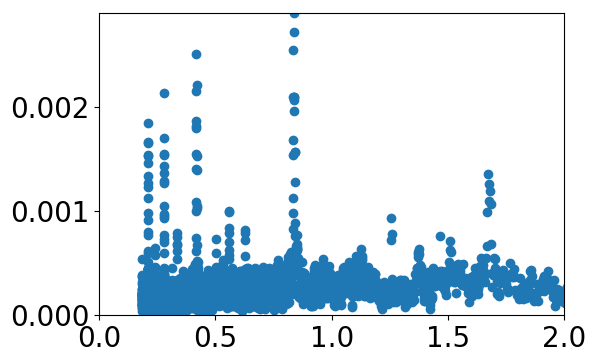

In [37]:
# Let's do an automated search for a planet-like signature
import bls
nf, fmin, df = 5000, 0.4, 0.001
results = bls.eebls(time, detrended, np.empty(time.shape), np.empty(time.shape), nf=nf, fmin=fmin, df=df, nb=5, qmi=0.005, qma=0.2)
power, best_period, best_power, depth, q, in1, in2 = results
pl.scatter(1 / np.arange(fmin, fmin+nf*df, df), power)
pl.xlim([0, 2])
pl.ylim([0, power.max()])
print("Looks like there's a planet with period {}".format(best_period))

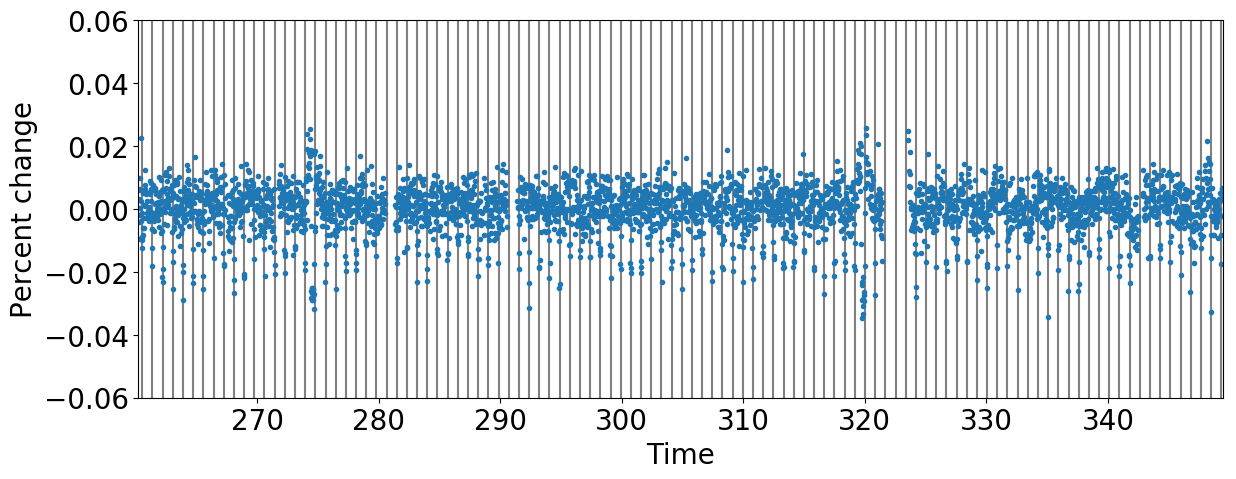

In [38]:
kep10b_period = 0.837495
kep10b_phase = 0.33

pl.figure(figsize=(14, 5))
pl.plot(time, detrended, '.')

pl.vlines(np.arange(time[0] + kep10b_phase, time[-1], kep10b_period), -0.5, 0.5, color='gray')
pl.xlim([time[0], time[-1]])
pl.ylim([-0.06, +0.06])
pl.ylabel("Percent change")
pl.xlabel("Time")


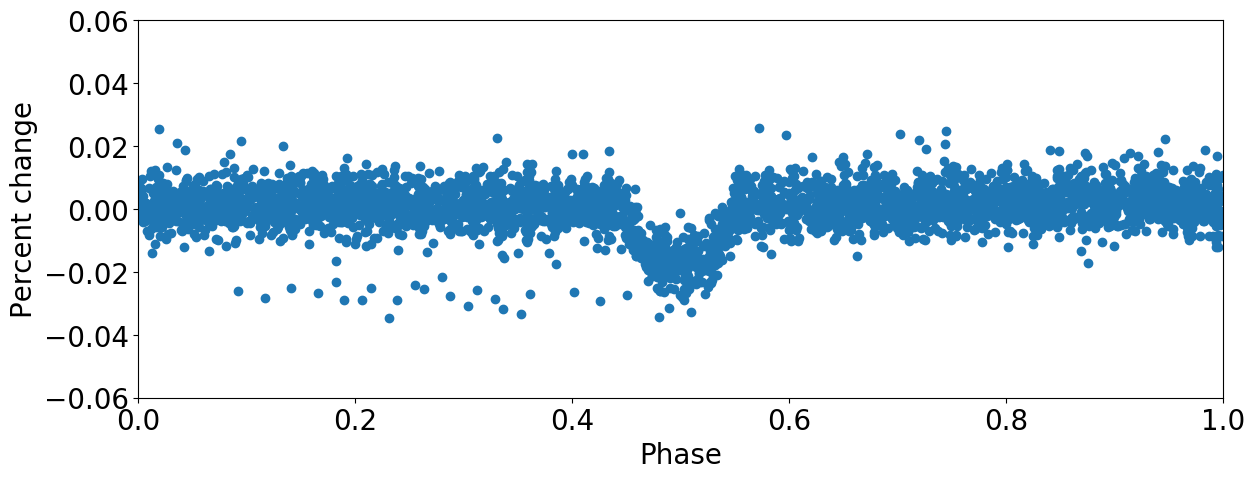

In [39]:
# Folded lightcurve
time_folded = ((time + kep10b_phase) / kep10b_period) % 1
pl.figure(figsize=(14, 5))
pl.scatter(time_folded, detrended)
pl.xlim([0, 1])
pl.ylim([-0.06, +0.06])
pl.xlabel("Phase")
pl.ylabel("Percent change")

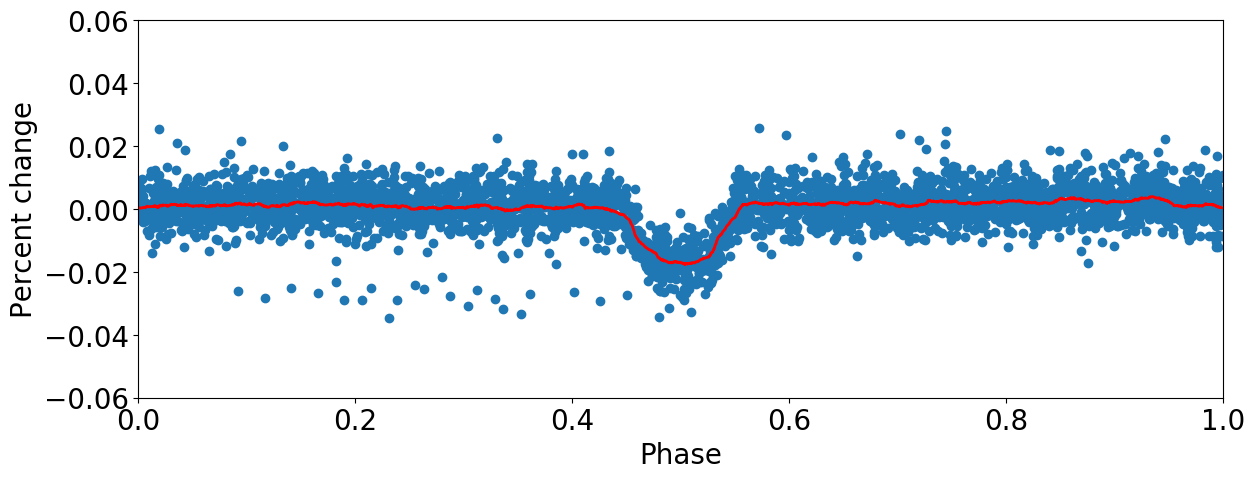

In [40]:
# Folded lightcurve
time_folded = ((time + kep10b_phase) / kep10b_period) % 1
pl.figure(figsize=(14, 5))
pl.scatter(time_folded, detrended)
pl.xlim([0, 1])
pl.ylim([-0.06, +0.06])
pl.xlabel("Phase")
pl.ylabel("Percent change")

# Plot a running mean as a red line
srt = np.argsort(time_folded)
running_mean = np.convolve(detrended[srt], np.ones((100,))/100, mode='same')
pl.plot(time_folded[srt], running_mean, c='red', lw=2)